In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn import metrics
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [34]:
df1 = pd.read_csv('/content/train.csv', delimiter=',')
df1['Title'] = df1['Title'].astype(str)
df1['Post'] = df1['Post'].astype(str)
nRow, nCol = df1.shape
print(f'Rows: {nRow}, Columns: {nCol}')

Rows: 36547, Columns: 3


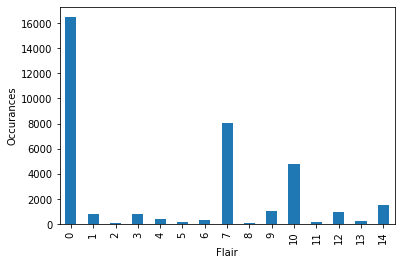

In [35]:
df1.groupby('Flair')['Title'].nunique().plot(kind='bar')
plt.ylabel("Occurances")
plt.show()

In [36]:
df1['Combine'] = df1['Title'] # Create a column combined

for i in range(len(df1)):
        df1['Combine'][i] = df1['Combine'][i] + ' ' + df1['Post'][i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [37]:
df1.head()

,Title,Post,Flair,Combine
0,netflix the family has been an amazing watch d...,netflixs new series the family is about a secr...,10,netflix the family has been an amazing watch d...
1,all results are out is iiitm gwalior it branch...,the internet seems to think so average package...,0,all results are out is iiitm gwalior it branch...
2,which are the things you always buy made in india,you can include the reason for your preference...,0,which are the things you always buy made in in...
3,weekly coders hackers amp all tech related thr...,last week issue all threads every week on frid...,11,weekly coders hackers amp all tech related thr...
4,what are some good unknown companies to work a...,there are similar posts on other subreddits bu...,0,what are some good unknown companies to work a...


In [38]:
df1['Combine'] = df1['Combine'].fillna('')

In [39]:
#tokenization
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [40]:
counts = Counter()
for index, row in df1.iterrows():
    counts.update(tokenize(row['Combine']))

In [41]:
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 88692
num_words after: 42720


In [42]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [43]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [44]:
df1['encoded'] = df1['Combine'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df1.head()

,Title,Post,Flair,Combine,encoded
0,netflix the family has been an amazing watch d...,netflixs new series the family is about a secr...,10,netflix the family has been an amazing watch d...,"[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 3, 13, 5..."
1,all results are out is iiitm gwalior it branch...,the internet seems to think so average package...,0,all results are out is iiitm gwalior it branch...,"[[32, 53, 54, 55, 25, 1, 56, 57, 58, 59, 3, 60..."
2,which are the things you always buy made in india,you can include the reason for your preference...,0,which are the things you always buy made in in...,"[[82, 54, 3, 83, 11, 84, 85, 86, 30, 87, 11, 6..."
3,weekly coders hackers amp all tech related thr...,last week issue all threads every week on frid...,11,weekly coders hackers amp all tech related thr...,"[[110, 111, 112, 113, 32, 114, 115, 116, 117, ..."
4,what are some good unknown companies to work a...,there are similar posts on other subreddits bu...,0,what are some good unknown companies to work a...,"[[14, 54, 48, 59, 158, 159, 18, 160, 15, 30, 8..."


In [45]:
X = list(df1['encoded'])
y = list(df1['Flair'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [47]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [48]:
next(iter(train_dl)) 

[tensor([[24113, 24114,   869,  ...,  1465,  4193,  1508],
         [   14,    53,    47,  ...,    30,  1143,   182],
         [   14,    53,    47,  ...,   513,  1831,    47],
         ...,
         [    3,    48,    49,  ...,     0,     0,     0],
         [  857,     3,  2889,  ...,     0,     0,     0],
         [   14,    25, 12807,  ...,     0,     0,     0]], dtype=torch.int32),
 tensor([10.,  0.,  1.,  ..., 10.,  0.,  0.], dtype=torch.float64),
 tensor([70, 70, 70,  ..., 40, 41, 27])]

In [100]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        # for x, y, l in train_dl:
        #   x = x.to(device)
        #   y = y.to(device)
        #   l = l.to(device)
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse, y_true, y_predt = validation_metrics(model, val_dl)
        if i % 5 == 0:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
            print(metrics.classification_report(y_true, y_predt, digits=3))


def validation_metrics (model, valid_dl):
    model.eval()
    y_true = []
    y_predt = []
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.

    # for x, y, l in valid_dl:
    #     x = x.to(device)
    #     y = y.to(device)
    #     l = l.to(device)
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        y_true = y.numpy()
        y_predt = pred.numpy()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total, y_true, y_predt

In [101]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [102]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers= 2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 15)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [103]:
model = LSTM_variable_input(vocab_size, 50, 50)
# model = model.to(device)

In [ ]:
train_model(model, epochs=30, lr=0.3)

train loss 3.840, val loss 3.414, val accuracy 0.456, and val rmse 6.478
              precision    recall  f1-score   support

           0      0.459     0.994     0.628      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.125     0.002     0.004       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.000     0.000     0.000       310
          11      0.000     0.000     0.000        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.457      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 2.009, val loss 1.965, val accuracy 0.456, and val rmse 6.467
              precision    recall  f1-score   support

           0      0.461     0.992     0.630      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.273     0.006     0.011       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.500     0.006     0.013       310
          11      0.000     0.000     0.000        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.458      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 1.808, val loss 1.764, val accuracy 0.456, and val rmse 6.468
              precision    recall  f1-score   support

           0      0.460     0.989     0.628      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.444     0.008     0.015       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.048     0.003     0.006       310
          11      0.000     0.000     0.000        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.456      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 1.723, val loss 1.692, val accuracy 0.457, and val rmse 6.472
              precision    recall  f1-score   support

           0      0.459     0.992     0.628      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.333     0.004     0.008       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.250     0.010     0.019       310
          11      1.000     0.038     0.074        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.458      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 1.715, val loss 1.689, val accuracy 0.457, and val rmse 6.465
              precision    recall  f1-score   support

           0      0.459     0.992     0.628      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.071     0.002     0.004       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.286     0.006     0.013       310
          11      0.000     0.000     0.000        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.456      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train loss 1.720, val loss 1.695, val accuracy 0.457, and val rmse 6.466
              precision    recall  f1-score   support

           0      0.459     0.992     0.627      1060
           1      0.000     0.000     0.000        45
           2      0.000     0.000     0.000         7
           3      0.000     0.000     0.000        40
           4      0.000     0.000     0.000        28
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        16
           7      0.286     0.004     0.008       522
           8      0.000     0.000     0.000         4
           9      0.000     0.000     0.000        68
          10      0.111     0.003     0.006       310
          11      0.000     0.000     0.000        26
          12      0.000     0.000     0.000        66
          13      0.000     0.000     0.000        12
          14      0.000     0.000     0.000        91

    accuracy                          0.457      2310
   macr

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
